# Forecasting the spot price of Mexican Oil


Oil is one of the most important traded commodities in the world and a much needed resource for economic growth. Despite the undergoing energy transition, it remains a strong input in the world's primary energy mix. Notably, oil producing countries such as Mexico are affected, for better or worse, by its price.

Continuing with the example of Mexico, [oil revenues account for 18% of its government budget.](https://ciep.mx/ley-de-ingresos-de-la-federacion-2019/) When one fifth of the public budget comes from oil revenues, it is no exageration to say that the oil price could make or break the government's income. 

Consequently, one must-have ability of as energy analysts is forecasting oil price. **In this notebook I show how to forecast the price of the Mexican Crude Oil (MMA)**. I develop a highly simplified Vector Autorregressive Model (VAR) to showcase the fundamentals of undertaking time-series analysis **using Python** to forecast the MMA price.

If you've read about how to model time-series you will surely have heard about the ARIMA family of models. While they are useful in some situations I would argue that to forecast oil prices the VAR model is more suitable. These are the reasons:

+ VAR models allow for multivariate time-series analysis (ARIMA are univariate). This means that a variable can depend on its own lags or lags from other variables.
+ The literature has found that VAR results are often better than structural models.
+ It is flexible enough to model a mix of endogenous and exogenous variables. Therefore it can capture strucutral behaviours as well as external influences to the system.   

**In summary, the VAR model is flexible and generalizes easily**. For an introductory treatment of the model you can see Chris Brooks': *Introductory Econometrics for Finance*.

**Disclaimer:** I am providing a basic guide for the interested readers on how the basic issues need to be addressed. By no means this is an exhaustive treatment of how to do time-series forecasting. I don't argue it is the best or only way or that it is 100% correct. 

## Base VAR model and data

The first step in the process is to think which variables could be useful in explaining the behaviour of the MMA's price. Theory or subject matter expertise are common sources that guide the choosing of relevant variables. For this model I will use the following **variables** in the model:

+ the spot prices of the MMA, WTI and Brent crude oil
+ the GDP of the Mexican economy
+ and the GDP of the United States

The prices of the WTI and Brent are chosen because they are the international benchmarks for the price of oil. It is likely that they will give relevant insights into the behavoiour of the MMA. On the other hand, the GDPs of Mexico and the United States are chosen to capture the impact of economic activity on oil prices. The academic literature has long established the relationship between economic growth and energy consumption, which in turn affects the price. For the MMA it is valuable to include the U.S. GDP because of the close economic link between the two countries.    

### Loading data

I have previously downloaded the data corresponding to the variables chosen for the model. You can find them in the data folder on this repository and check it in more detail. One issue needs to be addressed to have the data ready for time-series modelling.  

The 5 series are in different time periods: spot prices are daily and the GDPs have a quarterly frequency. I resample spot prices to the average quarterly values. The comments on the following code cells quickly explain the nature of the processing. 

**Let's begin**. 

In [1]:
# Load libraries
import os                     # Used for manipulation of files
import pandas as pd           # Base data wranlging package
import numpy as np            # Used for array manipulations and functions
import matplotlib.pyplot as plt    # For plotting
import matplotlib.dates as mdates  # Time index plot format
import seaborn as sns              # For enhanced statistical plotting capabilites
import statsmodels.api as sm       # Package for econometrics and time-series modelling
from statsmodels.tsa.api import VAR, DynamicVAR    # VAR model
from statsmodels.tsa.stattools import adfuller     # Function to test for stationarity


%matplotlib inline 

In [2]:
# Navigate file structure to check for
# correct names and import correctly 
%ls data

 El volumen de la unidad C es Windows
 El número de serie del volumen es: 7478-4309

 Directorio de C:\Users\artre\Dropbox\Portfolio\Forecasting_Oil_Price\data

06/08/2019  01:47 p. m.    <DIR>          .
06/08/2019  01:47 p. m.    <DIR>          ..
23/07/2019  04:25 p. m.             6,005 demanda_agregada_mexico.xlsx
01/08/2019  12:03 p. m.             6,131 pib_mexico.xlsx
23/07/2019  05:25 p. m.           109,431 spot_mezcla_mexicana_banxico.xlsx
23/07/2019  04:36 p. m.           178,176 spot_prices_brent_WTI.xls
01/08/2019  12:39 p. m.            20,480 US_gdp.xls
01/08/2019  12:43 p. m.            20,992 US_TradeBalanceGoods.xls
               6 archivos        341,215 bytes
               2 dirs  918,298,140,672 bytes libres


In [3]:
# Because we have GDP and demand measures I want to 
# work in quarterly periods, the idea es to
# load each file and parse the date for quaretrs if periodicity is different

# Petroleum prices

## Mexican crude oil

### Read files from excel
mma = pd.read_excel('data\\spot_mezcla_mexicana_banxico.xlsx',
              sheet_name= 'Hoja1', names = ['date', 'spot_mma'],
             skiprows=17)

### Set date column as index for series
mma = mma.set_index('date')

### Resample to the quarterly average price
mma = mma.resample('Q').mean()

## WTI and Brent

brent_wti = pd.read_excel('data\\spot_prices_brent_WTI.xls',
              sheet_name= 'Data 1', names = ['date', 'wti_spot','brent_spot'],
             skiprows=2)

brent_wti = brent_wti.set_index('date')
brent_wti = brent_wti.resample('Q').mean()

# Macroeconomic variables

## Mexican GDP

mex_gdp = pd.read_excel('data\\pib_mexico.xlsx',
              sheet_name= 'Hoja1', names = ['date', 'gdp_mex'],
             skiprows=17)

mex_gdp = mex_gdp.set_index('date')
mex_gdp = mex_gdp.resample('Q').mean()

## US GDP

us_gdp = pd.read_excel('data\\US_gdp.xls',
              sheet_name= 'FRED Graph', names = ['date', 'gdp_us'],
             skiprows=10)

us_gdp = us_gdp.set_index('date')
us_gdp = us_gdp.resample('Q').mean()

### Quick exploratory analysis

Plotting the data is one of the first steps involved when doing data analysis. It is useful to check that the information has been loaded correctly and to derive some useful insights about its nature. From the following plots I would note two things. 

1. **The three crude oil prices share similar behaviours**. It is likely that each price gives information that helps explain the others. 
2. **Oil prices in the last decade exhibit high volatility**. 
3. **The time index in the series is different**. For example,  the GDP of the US has information since the 1940's while. This means it will be neccesary to drop some NA values when modelling the VAR.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Billion USD')

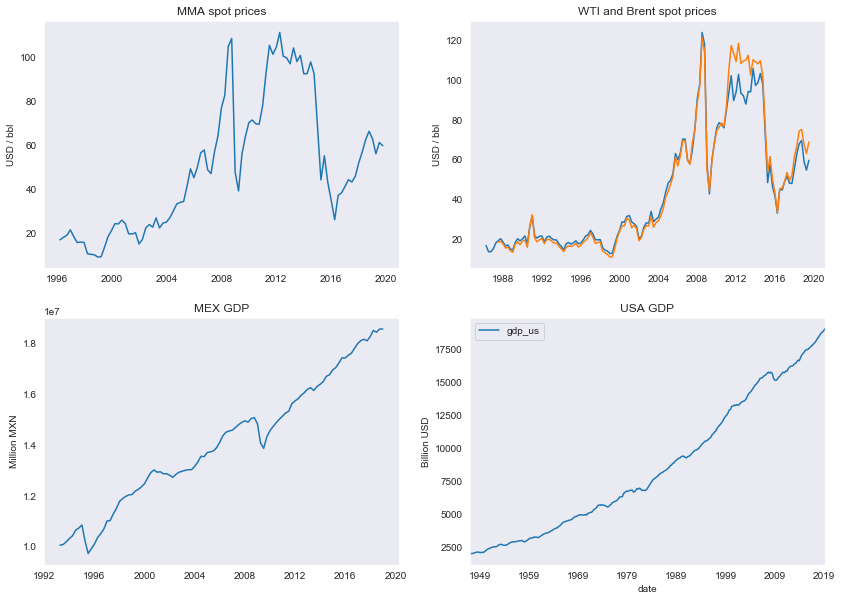

In [4]:
sns.set_style('dark')
fig = plt.figure(figsize= (14,10))

ax1 = fig.add_subplot(221)
plt.plot(mma)
plt.title('MMA spot prices')
plt.ylabel('USD / bbl')

ax2 = fig.add_subplot(222)
plt.plot(brent_wti)
plt.title('WTI and Brent spot prices')
plt.ylabel('USD / bbl')

ax3 = fig.add_subplot(223)
plt.plot(mex_gdp)
plt.title('MEX GDP')
plt.ylabel('Million MXN')

ax4 = fig.add_subplot(224)
#plt.plot(us_gdp)
us_gdp.plot(ax = ax4)
plt.title('USA GDP')
plt.ylabel('Billion USD')

## Data preprocessing for time-series modelling

Data processing for time-series analysis is cumbersome. Thankfully, the pandas package has convenient methods to store, slice, manipulate and transform data to be useful for modelling. The modelling of time-series requires that data is stationary (see the Brooks' book referenced in the introduction for a complete treatment on the topic. Financial data such as prices and GDP are commonly transformed to logarithms and then differenced. In time-series jargon, the log series are integrated order 1.

The above transformation has an appealing economic interpretation:

+ For price series, the first difference of the log price is equal to the returns.
+ For GDP series, the first difference of the log GDP is equal to economic growth. 

The following cells show the code to creat a data frame, apply logarithm and first differenc to each series, and plot the resulting series.  

In [5]:
# Join data to a single data frame 
# taking advantage of the time index
# Outer join is chosen in order to not lose observations

df = mma.join(brent_wti, how='outer')
df = df.join(mex_gdp, how = 'outer')
df = df.join(us_gdp, how = 'outer')

## Apply logarithm to each of the series (columns)
df[['spot_mma', 'wti_spot', 'brent_spot', 'gdp_mex', 'gdp_us']] = df[['spot_mma', 'wti_spot', 'brent_spot', 'gdp_mex', 'gdp_us']].apply(np.log, axis = 'columns')
df.info()
print('-'*80)
print('*Notice the difference in null values for each series, this is because of the\n different time indexes of the series.')
print('-'*80)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 291 entries, 1947-03-31 to 2019-09-30
Freq: Q-DEC
Data columns (total 5 columns):
spot_mma      95 non-null float64
wti_spot      134 non-null float64
brent_spot    129 non-null float64
gdp_mex       104 non-null float64
gdp_us        290 non-null float64
dtypes: float64(5)
memory usage: 13.6 KB
--------------------------------------------------------------------------------
*Notice the difference in null values for each series, this is because of the
 different time indexes of the series.
--------------------------------------------------------------------------------


In [6]:
# Transform variables to the first difference
# using the diff method from pandas

df['spot_mma_growth'] = df['spot_mma'].diff()
df['wti_spot_growth'] = df['wti_spot'].diff()
df['brent_spot_growth'] = df['brent_spot'].diff()
df['gdp_growth_us'] = df['gdp_us'].diff()
df['gdp_growth_mex'] = df['gdp_mex'].diff()
df_growth = df[['spot_mma_growth', 'wti_spot_growth', 'brent_spot_growth', 'gdp_growth_mex', 'gdp_growth_us']]

Text(0.5, 1.0, 'Quarterly Oil price returns and GDP growth rates')

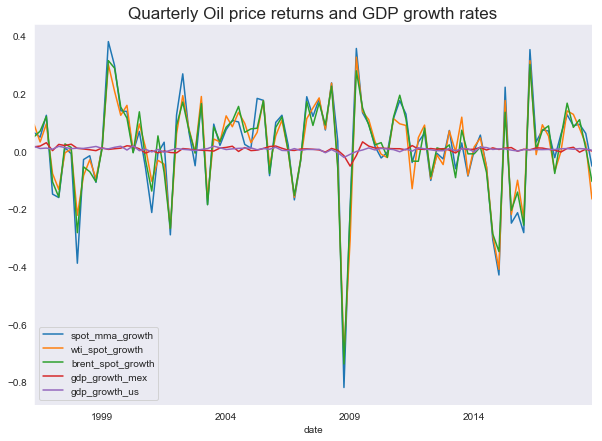

In [7]:
# Check the behaviour of the series to derive insights
# Only use time peridos where all series have information

df_growth.dropna().plot(figsize=(10,7))
plt.title('Quarterly Oil price returns and GDP growth rates', size = 17)

### Some insights from the plot

+ It looks like the returns and growth have constant mean, and except for some points also constant variance.
+ Oil price returns exhibit significant volatility throughout the considered period.
+ It looks ike the behaviour of oil prices is correlated.
+ GDP growth between Mexico and the US appears to be related. 

## Testing for stationarity. The Augmented Dickey-Fuller Test

A fundamental stage to model any time series is making sure the data is stationary. The Augmented Dickey-Fuller (ADF) Test is a widely used approach to test for stationarity. Instead of writing repeated code to perform the ADF on each variable, the following code cell shows that using a for-loop streamlines the process. Some print statements are used to convey the decision. 

You can find [here] (https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) the documentation for the ADF test implementation in stats model. 

**Test results**: The null hypothesis is rejected for all variables. It is sensible to confirm that our data is stationary and ready for modelling. 

In [8]:
print('Augmented Dickey-Fuller Test')
print('Null hypothesis: the series have a unit root. That is, are not stationary.')
print('Unit root test results:')
print('-'*60)

for variable in df_growth.columns:
    x = df[variable].dropna() #Remove null values
    test = adfuller(x, maxlag = 4 , autolag ='AIC', store = True) #Perform the test
    DFstat = test[0] # Recover the test statistic from the test object
    pval = test[1]   # Recover the p-value from the test object
    
    # Use an if statment to decide wether or not the null hypothesis can be rejected
    # at a 5% significance level
    if pval < 0.05:
        decision = 'Reject null hypothesis; no unit root.'
    else:
        decision = 'Do not reject null hypothesis; unit root.'

    print('Variable being tested: ' + variable)
    print('ADF test statistic: ' + str(np.round(DFstat, 3)))
    print('P-value: ' + str(np.round(pval, 3)))
    print('Decision at 5% significance: ' + decision)
    print('-'*60)

Augmented Dickey-Fuller Test
Null hypothesis: the series have a unit root. That is, are not stationary.
Unit root test results:
------------------------------------------------------------
Variable being tested: spot_mma_growth
ADF test statistic: -7.38
P-value: 0.0
Decision at 5% significance: Reject null hypothesis; no unit root.
------------------------------------------------------------
Variable being tested: wti_spot_growth
ADF test statistic: -6.644
P-value: 0.0
Decision at 5% significance: Reject null hypothesis; no unit root.
------------------------------------------------------------
Variable being tested: brent_spot_growth
ADF test statistic: -6.078
P-value: 0.0
Decision at 5% significance: Reject null hypothesis; no unit root.
------------------------------------------------------------
Variable being tested: gdp_growth_mex
ADF test statistic: -7.051
P-value: 0.0
Decision at 5% significance: Reject null hypothesis; no unit root.
--------------------------------------------

## Create the VAR model

As you can see, processing and transforming the data is the bulk of the modelling process, albeit a very important step. With all of it finished, it is at last time to build and fit the VAR model to the data. 

Three considerations need to be solved before fitting the VAR model:

1. Specification of the model
2. Results of interest
3. In-sample and out-of-sample forecast

### 1. Model specification

I argued in the introduction that the spot MMA price is affected by the price of the WTI and Brent, as well as the GDP of Mexico and United States. Nevertheless, it is important to make a distinction between endogenous and exogenous variables. In the VAR model, the values of endogenous variables are determined inside the model. However, it is unlikely that GDP growth in Mexico and the US is driven by the oil price. As any elementary macroeconomics textbook will show, GDP is related to consumption, savings, investment, inflation rates, among others. Consequently, GDP is probably better integrated to the model as an exogenous variable that affects oil price. 

On the other hand, it is likely that the prices for the three different crude oil series are determined inside the model. This is because the high correlation in their returns. Also for some economic reasons. Being WTI and Brent the benchmark prices, the MMA price will surely follow or be affected by their changes. 

Additionally, the lag order selection is crucial to the model. In this sense, information criteria sucha as Akaike Information Criteria (AIC) are helpful in determining the order of lags.

In summary: MMA, WTI and Brent prices are endogenous variables; US and Mexico's GDP are exogenous. 

### 2. Results of interest

VAR models can quickly escalte in size and be difficult to interpret. Therefore, it is common to only be interested in checking how well the model fits, measures of causality between endogenous variables and what effects do shocks in the endogenous vairables have in the system. 

+ The first issue is can be solved by computing measures of error deviations like the Root Mean Sqyare Error (RMSE) and plotting the predicted vs. the real values.

+ Because true causation is difficult to establish, a more relaxed statement about causation can be determined with the concepto of Granger Causality. Granger Causality tries to answer questions like "Does X causes Y" by implying correlation and not causation. The answer, if Granger Causality is found, would be "X is helpful in predicting the changes of Y"; note that it never states X causes Y. 

+ To see how shocks in the endogenous variables affect the system Impulse Response Analysis is used. 

### 3. In-sample and out-of-sample forecasts. 

Models that seem to have good performace when forecasting in-sample data may have bad performance where forecasting out-of-sample data. ["Empirical evidence based on out-of-sample forecast performance is generally considered more trustworthy than evidence based on in-sample performance"](https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:In-sample_vs._out-of-sample_forecasts). This is why it is good practice to split the data set in a train set and then have a validation set. I present how to do both. 



## In-sample VAR estimation 

In [9]:
# Make the model and get summary of data
## Build the model
df_var = df_growth.dropna()
df_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 1996-06-30 to 2018-12-31
Freq: Q-DEC
Data columns (total 5 columns):
spot_mma_growth      91 non-null float64
wti_spot_growth      91 non-null float64
brent_spot_growth    91 non-null float64
gdp_growth_mex       91 non-null float64
gdp_growth_us        91 non-null float64
dtypes: float64(5)
memory usage: 4.3 KB


In [10]:
# Create VAR model
var_model = VAR(endog=df_var.iloc[:,0:3], exog=df_var.iloc[:,3:5])

# Check the optimum order of lags
# Decide based on AIC or any other measure
var_model.select_order(4).summary() 

,AIC,BIC,FPE,HQIC
0,-16.65,-16.40*,5.855e-08,-16.55*
1,-16.70*,-16.19,5.607e-08*,-16.49
2,-16.61,-15.85,6.114e-08,-16.30
3,-16.54,-15.52,6.590e-08,-16.13
4,-16.42,-15.15,7.435e-08,-15.91


In [11]:
# Fit VAR model and store the results as an object
var_results = var_model.fit(maxlags=4, ic='aic')

In [12]:
# Get the table of coefficients
## Note that exog0 = MEX GDP
## Note that exog1 = US GDP
var_results.params

,spot_mma_growth,wti_spot_growth,brent_spot_growth
const,-0.042434,-0.043624,-0.039183
exog0,0.346155,0.799931,0.530244
exog1,8.394041,7.633862,7.689658
L1.spot_mma_growth,-0.179515,-0.213508,-0.271219
L1.wti_spot_growth,-1.073964,-0.837639,-0.617220
L1.brent_spot_growth,1.408346,1.238901,1.072630


In [13]:
# Get t-values for significance
var_results.tvalues

,spot_mma_growth,wti_spot_growth,brent_spot_growth
const,-1.715735,-2.042136,-1.780364
exog0,0.155507,0.416059,0.267689
exog1,2.517457,2.650694,2.591639
L1.spot_mma_growth,-0.388510,-0.534982,-0.659624
L1.wti_spot_growth,-2.232207,-2.015698,-1.441654
L1.brent_spot_growth,2.471898,2.517572,2.115668


## Interpretation of exogenous variables effects on spot MMA price

+ The coefficients for the GDP of Mexico and the US are positive as expected. If GDP grows, demand for oil grows and prices will increase. 
+ The US GDP growth is significant when contrasting the t statistic to the critical value of 1.96 (5% significance level)
+ Looking at the equation for MMA spot prices, it can be seen that a 1% increase in US GDP increases, everything else constant, MMA spot prices in 8.4%.  

## Interpretation of endogenous variables on spot MMA price

As stated above, the interpretation of the endogenous variables is not straightforward in VAR models. In consequence, testing for granger causality, doing impulse response analysis, computing the RMSE and contrasting the predicted vs. the actual values is more informative.  

### Granger causality results

As the following results show, there is no bidirectional feedback between spot MMA and the benchmark prices. Only WTI and Brent prices granger cause the spot MMA price. This is inline with subject matter expertise propositions. This means that WTI and Brent prices are important variables that help explain the behvaviour of the Mexican crude oil price. 

In [14]:
var_results.test_causality(caused=0, causing= 1).summary()

Test statistic,Critical value,p-value,df
4.983,3.879,0.026,"(1, 252)"


In [15]:
var_results.test_causality(caused=0, causing= 2).summary()

Test statistic,Critical value,p-value,df
6.110,3.879,0.014,"(1, 252)"


In [16]:
var_results.test_causality(caused=1, causing= 0).summary()

Test statistic,Critical value,p-value,df
0.2862,3.879,0.593,"(1, 252)"


In [17]:
var_results.test_causality(caused=2, causing= 0).summary()

Test statistic,Critical value,p-value,df
0.4351,3.879,0.510,"(1, 252)"


### Model fit: predicted vs real values

To check the performance of the model the predicted vs. actual values are plotted. Looking at the plot we can see that:

+ The model has some troubles when predicting periods with high volatility like the 2009 crisis or periods from 2015-2016.
+ However, it looks that it smooths the series well and gets the behaviour correctly. 

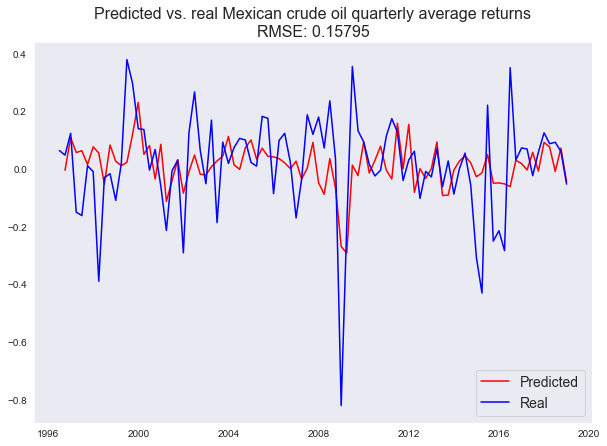

In [18]:
predicted = var_results.fittedvalues['spot_mma_growth']
real = df_var['spot_mma_growth']

rmse = np.round(np.sqrt(((predicted - real) ** 2).mean()),5)

title_RMSE = str('Predicted vs. real Mexican crude oil quarterly average returns\n' + 'RMSE: ' + str(rmse))

plt.figure(figsize=(10,7))
plt.plot(predicted, color = 'red', label = 'Predicted')
plt.plot(real, color = 'blue', label = 'Real')
plt.title(title_RMSE, size = 16)
plt.legend(loc = 'lower right', prop = {"size":14})

### Impulse response analysis

To see how the MMA spot price changes when there is a shock to WTI or Brent prices, following code cells show the plots of the Impulse Response results. 

+ When there is a unit shock to WTI prices, in the first quarter after the shock, the MMA price tends to decrease and then after 2 quarters it will increase. The effect of the shock fades after three quarters.
+ When there is a unit shock to Brent prices, in the first quarter after the shock, the MMA price tends to increase and then after 2 quarters it will decrease. The effect of the shock fades after three quarters.

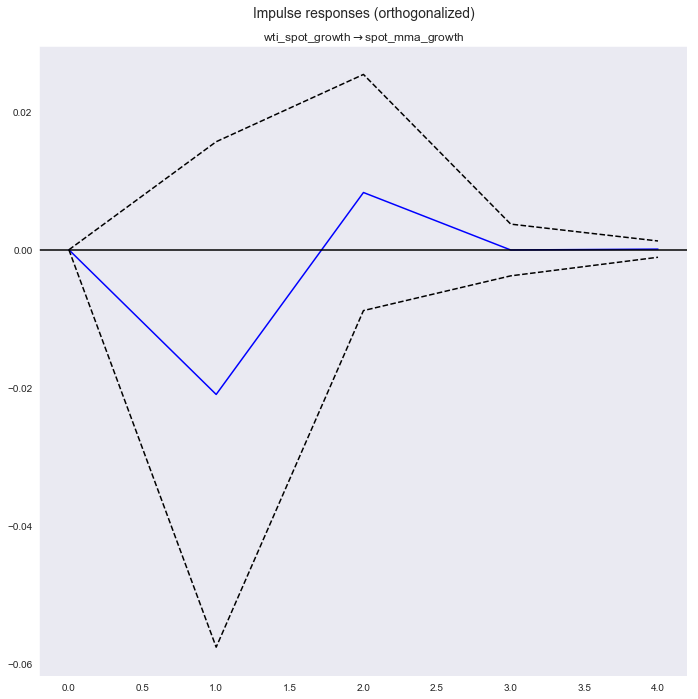

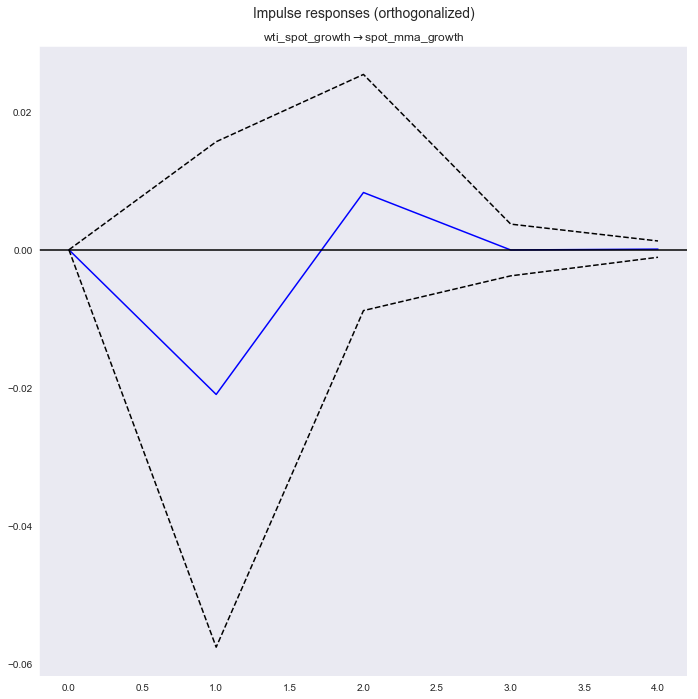

In [20]:
irf = var_results.irf(4)
irf.plot(orth = True, impulse = 'wti_spot_growth', response = 'spot_mma_growth')

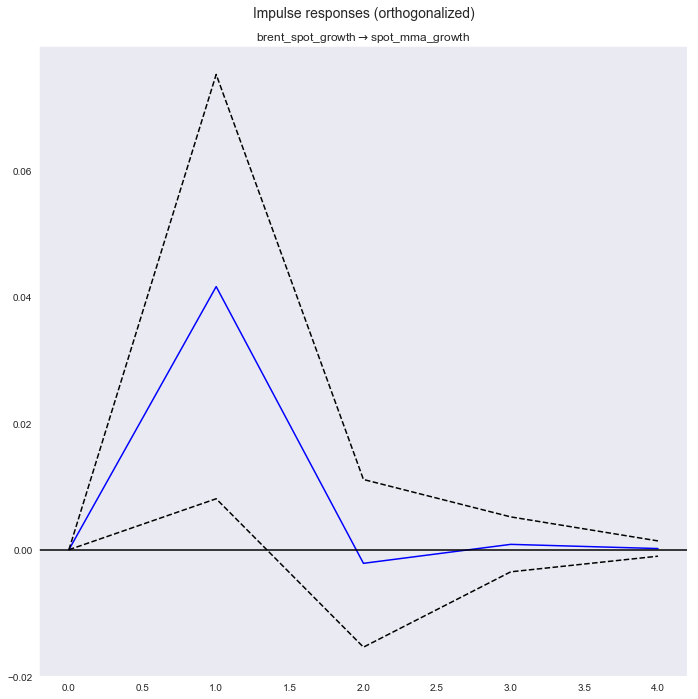

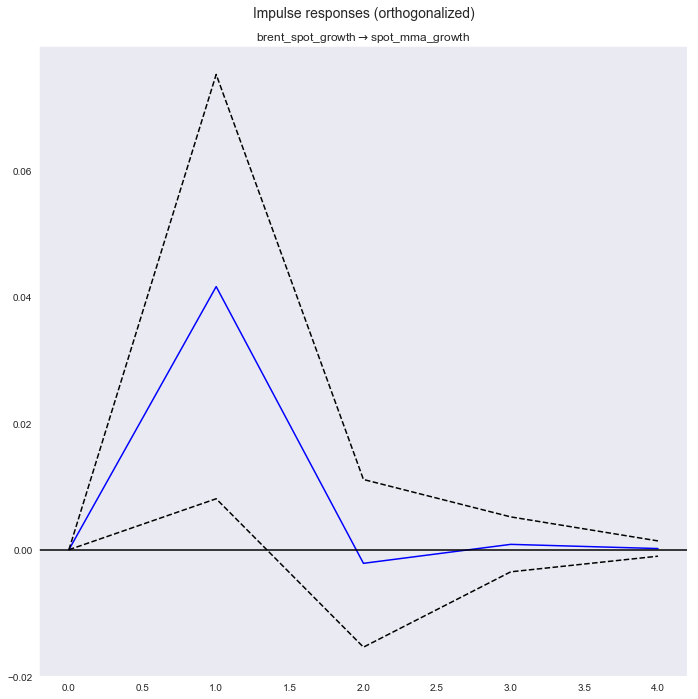

In [21]:
irf.plot(orth = True, impulse = 'brent_spot_growth', response = 'spot_mma_growth')

## Out-of-sample behaviour and forecasts

The above analyses were done as an in-sample model. Nevertheless, it is empircally more interesting to see what is the model's performance using out-of-sample date. I first split the data into test and validate sets; usual values used are 80% of data for test and 20% for validation . Then I plot the predicted vs real and compute the RMSE to see how it does.  

In [55]:
# Check the time sample from the VAR dataset
df_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 1996-06-30 to 2018-12-31
Freq: Q-DEC
Data columns (total 5 columns):
spot_mma_growth      91 non-null float64
wti_spot_growth      91 non-null float64
brent_spot_growth    91 non-null float64
gdp_growth_mex       91 non-null float64
gdp_growth_us        91 non-null float64
dtypes: float64(5)
memory usage: 6.8 KB


In [56]:
# Split the data: 80% data is for all quarters between 1996 and 2014
# 20% goes from 2014 to 2015
train = df_var['1996':'2014']
test =  df_var['2015':]

#Check split
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75 entries, 1996-06-30 to 2014-12-31
Freq: Q-DEC
Data columns (total 5 columns):
spot_mma_growth      75 non-null float64
wti_spot_growth      75 non-null float64
brent_spot_growth    75 non-null float64
gdp_growth_mex       75 non-null float64
gdp_growth_us        75 non-null float64
dtypes: float64(5)
memory usage: 3.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2015-03-31 to 2018-12-31
Freq: Q-DEC
Data columns (total 5 columns):
spot_mma_growth      16 non-null float64
wti_spot_growth      16 non-null float64
brent_spot_growth    16 non-null float64
gdp_growth_mex       16 non-null float64
gdp_growth_us        16 non-null float64
dtypes: float64(5)
memory usage: 768.0 bytes
None


In [57]:
# Create VAR model
var_model = VAR(endog=train.iloc[:,0:3], exog=train.iloc[:,3:5])
var_results = var_model.fit(maxlags=4, ic='aic')

# Predict values up to the validation
predicted_ofs = var_results.forecast(var_results.y, steps=len(test), exog_future = test.iloc[:,3:5])

#Get predicted MMA out-of-sample
predicted_MMA_ofs = predicted_ofs[:,0]
# Make OFS prediction a pandas time series for processing
predicted_MMA_ofs = pd.Series(predicted_MMA_ofs, index = test.index)

#Get predicted MMA in-of-sample
predicted_MMA_is = var_results.fittedvalues['spot_mma_growth']




# Get the predicted and actual values for the whole series

predicted = predicted_MMA_is.append(predicted_MMA_ofs)
real = df_var['spot_mma_growth']



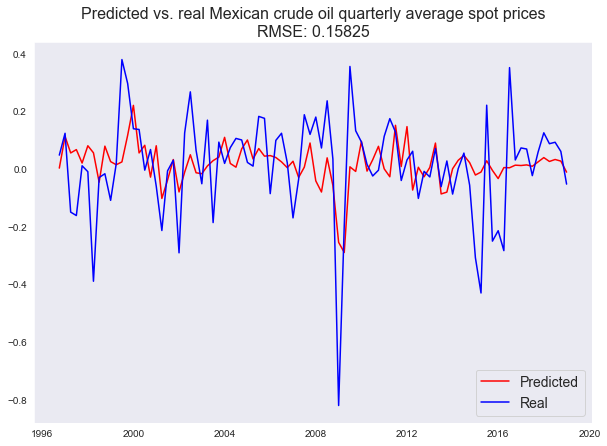

In [58]:
predicted = predicted[0:90]
real = real[1:91]

rmse = np.round(np.sqrt(((predicted - real) ** 2).mean()),5)

title_RMSE = str('Predicted vs. real Mexican crude oil quarterly average returns\n' + 'RMSE: ' + str(rmse))
plt.figure(figsize=(10,7))
plt.title(title_RMSE, size = 16)
plt.plot(predicted, color = 'red', label = 'Predicted')
plt.plot(real, color = 'blue', label = 'Real')
plt.legend(loc = 'lower right', prop = {"size":14})


In [86]:
#Going back to the original scale
mma_log = np.log(mma['spot_mma'])
predicted_cumsum = predicted.cumsum()
predicted_cumsum.head(), mma_log.head()

(date
 1996-03-31    17.032321
 1996-06-30    18.164444
 1996-09-30    19.065714
 1996-12-31    21.585345
 1997-03-31    18.591091
 Freq: Q-DEC, Name: spot_mma, dtype: float64, date
 1996-09-30    0.003326
 1996-12-31    0.116299
 1997-03-31    0.172254
 1997-06-30    0.239762
 1997-09-30    0.260739
 dtype: float64, date
 1996-03-31    2.835113
 1996-06-30    2.899466
 1996-09-30    2.947892
 1996-12-31    3.072015
 1997-03-31    2.922682
 Freq: Q-DEC, Name: spot_mma, dtype: float64)

In [91]:
log_predictions = mma_log.add(predicted_cumsum, fill_value=0)
value_predictions = np.round(np.exp(log_predictions),2)

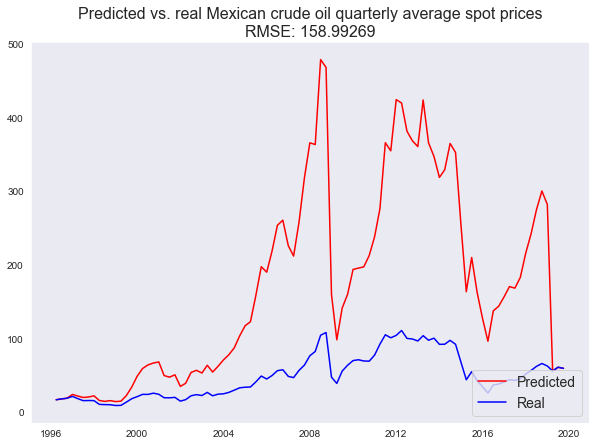

In [92]:
rmse = np.round(np.sqrt(((value_predictions - mma['spot_mma']) ** 2).mean()),5)

title_RMSE = str('Predicted vs. real Mexican crude oil quarterly average spot prices\n' + 'RMSE: ' + str(rmse))
plt.figure(figsize=(10,7))
plt.title(title_RMSE, size = 16)
plt.plot(value_predictions, color = 'red', label = 'Predicted')
plt.plot(mma['spot_mma'], color = 'blue', label = 'Real')
plt.legend(loc = 'lower right', prop = {"size":14})


## Arima

In [43]:
series = df_var['spot_mma_growth']

In [44]:
#sm.graphics.tsa.plot_acf(series, lags=20)
#sm.graphics.tsa.plot_pacf(series, lags=20)

In [46]:
model = sm.tsa.ARIMA(series, (1,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        spot_mma_growth   No. Observations:                   91
Model:                     ARMA(1, 0)   Log Likelihood                  31.385
Method:                       css-mle   S.D. of innovations              0.171
Date:                Mon, 05 Aug 2019   AIC                            -56.770
Time:                        15:39:11   BIC                            -49.238
Sample:                    06-30-1996   HQIC                           -53.731
                         - 12-31-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0143      0.022      0.663      0.509      -0.028       0.057
ar.L1.spot_mma_growth     0.1702      0.103      1.655      0.101      -0.031       0.372
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.8762           +0.0000j            5.8762            0.0000
-----------------------------------------------------------------------------
"""

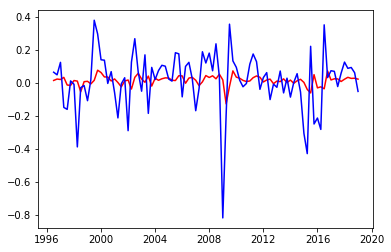

In [47]:
predicted = results.fittedvalues
real = df_var['spot_mma_growth']

plt.plot(predicted, color = 'red')
plt.plot(real, color = 'blue')

RMSE: 0.17136174352356798


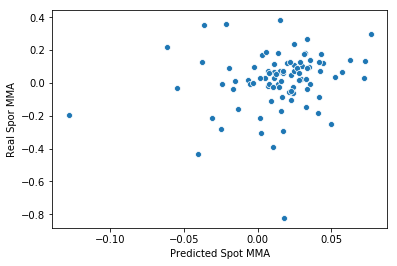

In [48]:
sns.scatterplot(predicted, real)
plt.xlabel('Predicted Spot MMA')
plt.ylabel('Real Spor MMA')

print('RMSE: ' + str(np.sqrt(((predicted - real) ** 2).mean())))